### 해야할 것들

1. Efficient Net 0
2. Efficient Net 1
3. Efficient Net 2 
4. MobileNet V2
5. MobileNet V3

각 모델들 데이터 전처리, 정규화, 학습 진행하고 안드로이드에 붙여보기

model은 0~1 사이 값을 input 받아야하니까 정규화 꼭 해야함.<br>
근데 안드로이드 스튜디오에서도 꼭 잊지 말고 해줘야함.<br>
byteByffer.putFloat(r / 255.0f);<br>
byteByffer.putFloat(g / 255.0f);<br>
byteByffer.putFloat(b / 255.0f);<br>

이렇게 255 안나누고 rgb 값만 추가하게 되면 여기 모델에서도 255 나눠서 학습시키면 안됨.<br>
꼭 통일하기!!!!!!!!!!!! 정신 차리고!!!!!!

In [2]:
import matplotlib.pylab as plt
import os
import datetime
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.layers import Flatten, Dense
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except RuntimeError as e:
    print("error",e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
num_epochs = 10

data_root = 'C:/Users/Etri/Desktop/eunsoo/images'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'validation')
batch_size = 32
img_height = 224
img_width = 224
image_shape = (img_width, img_height)
labels = ['Chat', 'noneChat']

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = np.array(train_ds.class_names)
print(class_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 7
Number of test batches: 6


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [12]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    feature_extractor_layer,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [15]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    callbacks=tensorboard_callback)

Epoch 1/10
50/50 [==============================] - 6s 66ms/step - loss: 0.4980 - accuracy: 0.7613 - val_loss: 0.3444 - val_accuracy: 0.8558
Epoch 2/10
50/50 [==============================] - 2s 42ms/step - loss: 0.3054 - accuracy: 0.8788 - val_loss: 0.2545 - val_accuracy: 0.8798
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.2423 - accuracy: 0.9119 - val_loss: 0.2087 - val_accuracy: 0.9183
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.2036 - accuracy: 0.9331 - val_loss: 0.1801 - val_accuracy: 0.9279
Epoch 5/10
50/50 [==============================] - 2s 42ms/step - loss: 0.1768 - accuracy: 0.9469 - val_loss: 0.1594 - val_accuracy: 0.9327
Epoch 6/10
50/50 [==============================] - 2s 43ms/step - loss: 0.1568 - accuracy: 0.9531 - val_loss: 0.1433 - val_accuracy: 0.9375
Epoch 7/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1410 - accuracy: 0.9606 - val_loss: 0.1303 - val_accuracy: 0.9519
Epoch 8/10
50

In [16]:
loss, accuracy = model.evaluate(test_ds)

6/6 [==============================] - 1s 28ms/step - loss: 0.1160 - accuracy: 0.9583


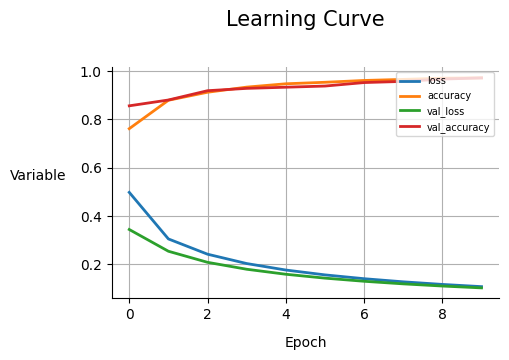

In [17]:
results = history.history

history_df = pd.DataFrame(results)
history_df.plot(figsize=(5,3), linewidth=2)

plt.grid(True)
plt.title("Learning Curve", fontsize = 15, pad=30)
plt.ylabel('Variable', fontsize = 10, rotation=0, loc='center', labelpad=30)
plt.xlabel('Epoch', fontsize=10, loc='center', labelpad = 10)
plt.legend(loc = "upper right", fontsize=7)

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [18]:
def isHalf(batch):
    id_list = []
    for i in batch:
        if (i < 0.5):
            id_list.append('Chat')
        else:
            id_list.append('noneChat')
    return id_list

predicted_batch = model.predict(image_batch)
predicted_id = isHalf(predicted_batch)
print(predicted_id)

def labelsCompare(batch):
    label_list = []
    for i in batch:
        if(i == 1):
            label_list.append('noneChat')
        else:
            label_list.append('Chat')
    return label_list

label_numpy = labels_batch.numpy() #Tensor to numpy (list로 쓰기 위해)
label_id = labelsCompare(label_numpy)
print(label_id)

1/1 [==============================] - 0s 283ms/step
['noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'Chat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat']
['noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'Chat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'Chat', 'noneChat', 'noneChat', 'Chat', 'noneChat', 'Chat', 'noneChat']


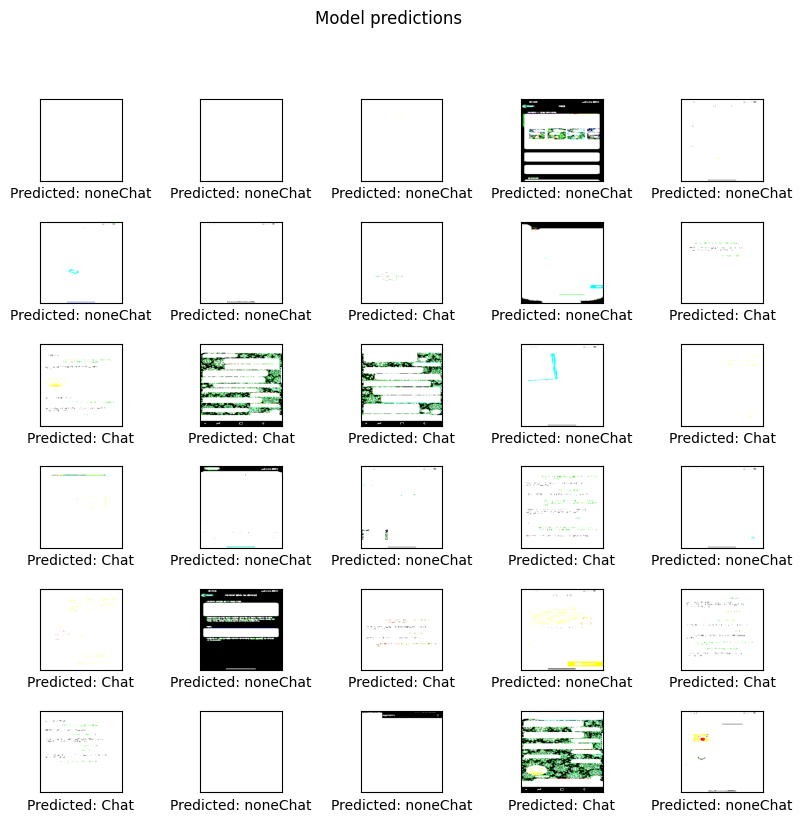

In [19]:
#라벨 맞는지 아닌지 글자색으로 표시해주는 함수
def get_label_color(val1, val2):
    if val1 == val2:
        return 'black' #맞으면 블랙
    else:
        return 'red' #아니면 레드

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    ax = plt.subplot(6,5,n+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[n])
    color = get_label_color(predicted_id[n],
                label_id[n])
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predicted_id[n])
    _ = plt.suptitle("Model predictions")

In [20]:
ver = '1'

# 이름 꼭 바꿔주기!!!!!!
model_name = 'mobilenet_no_normalize'
path = 'C:/Users/Etri/Desktop/eunsoo/models/mobilenet/'
model.save(path+ver+'.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open(path+model_name+ver+'.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Etri\AppData\Local\Temp\tmp_n18gxt1\assets


INFO:tensorflow:Assets written to: C:\Users\Etri\AppData\Local\Temp\tmp_n18gxt1\assets
